In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Task 1

RMSE: $36,238.17
R^2 Score: 0.8807
Predicted price for the new house: $612,163.88


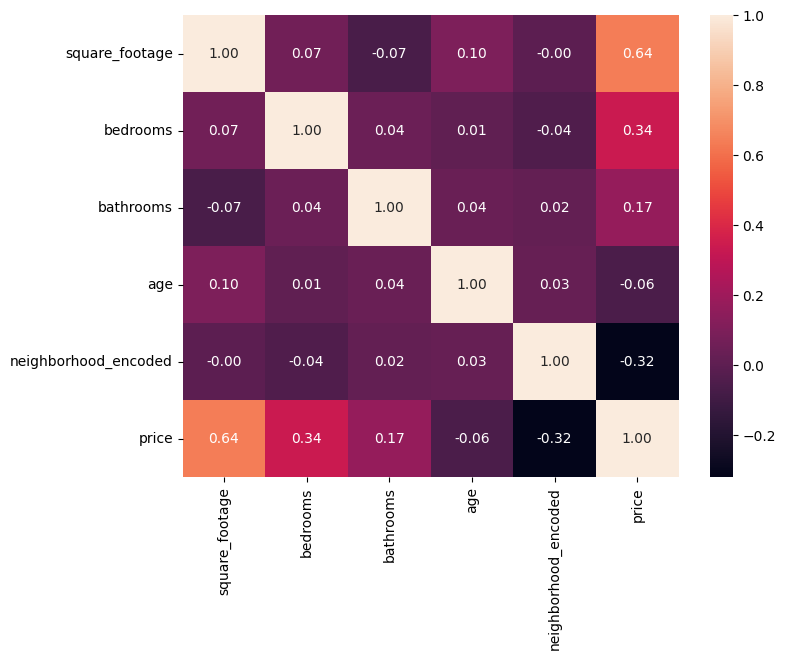

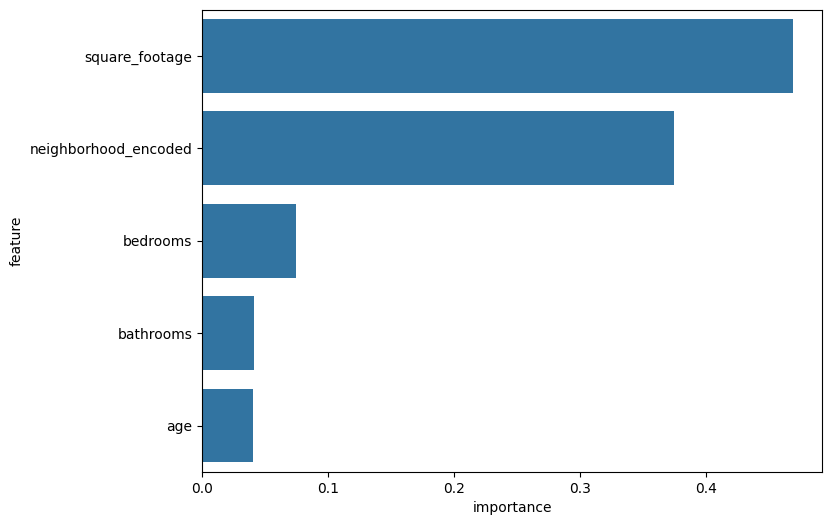

In [9]:
np.random.seed(727)

N = 1000
data = {
  'square_footage': np.random.normal(2000, 500, N),
  'bedrooms': np.random.randint(1, 6, N),
  'bathrooms': np.random.randint(1, 4, N),
  'age': np.random.randint(0, 50, N),
  'neighborhood': np.random.choice(['Downtown', 'Suburb', 'Rural'], N),
  'price': np.zeros(N)
}

for i in range(N):
  # forging price
  base_price = (
    data['square_footage'][i] * 150 +
    data['bedrooms'][i] * 20000 +
    data['bathrooms'][i] * 30000 -
    data['age'][i] * 1000
  )
  # scaling price
  neighborhood_modifier = {'Downtown': 1.2, 'Suburb': 1.0, 'Rural': 0.8}
  # assigning price
  data['price'][i] = base_price * neighborhood_modifier[data['neighborhood'][i]] + np.random.normal(0, 10000)

df = pd.DataFrame(data)

# add missing values
df.loc[np.random.choice(df.index, 50), 'square_footage'] = np.nan
df.loc[np.random.choice(df.index, 30), 'bathrooms'] = np.nan

df['square_footage'] = df['square_footage'].fillna(df['square_footage'].median())
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])

le = LabelEncoder()
df['neighborhood_encoded'] = le.fit_transform(df['neighborhood'])

features = ['square_footage', 'bedrooms', 'bathrooms', 'age', 'neighborhood_encoded']
X = df[features]
y = df['price']

plt.figure(figsize=(8, 6))
sns.heatmap(df[features + ['price']].corr(), annot=True, fmt='.2f')

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = \
  pd.DataFrame({'feature': features, 'importance': rf.feature_importances_})\
  .sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: ${rmse:,.2f}")
print(f"R^2 Score: {r2:.4f}")

new_house = pd.DataFrame({
  'square_footage': [2500],
  'bedrooms': [4],
  'bathrooms': [3],
  'age': [10],
  'neighborhood': ['Downtown']
})
new_house['neighborhood_encoded'] = le.transform(new_house['neighborhood'])
new_house_features = new_house[features]
new_house_scaled = scaler.transform(new_house_features)
predicted_price = model.predict(new_house_scaled)[0]

print(f"Predicted price for the new house: ${predicted_price:,.2f}")

## Task 2

Accuracy: 98.55


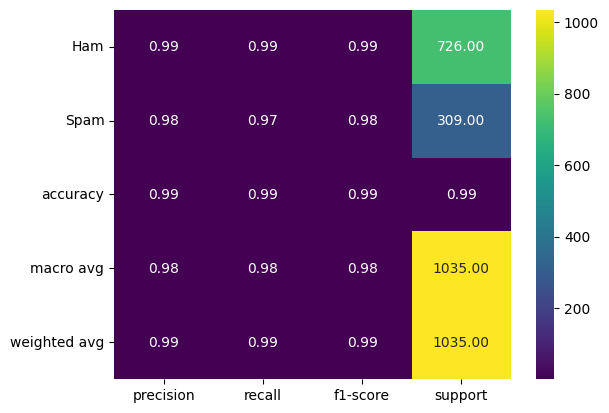

Predictions:
Spam | Win a free vacation! Click to claim your prize!


In [88]:
df = pd.read_csv('spam_ham_dataset.csv').iloc[:, 2:].rename(columns={ 'label_num': 'spam' })

def clean_text(text: str) -> str:
  return ' '.join(re.sub(r'[^a-zA-Z\s]', '', text).lower().split())

df['text'] = df['text'].apply(clean_text)

X = df['text']
y = df['spam']

vect = TfidfVectorizer(max_features=len(df), stop_words='english')
X_tfidf = vect.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=727)

model = LogisticRegression(random_state=727)
model.fit(X_train.toarray(), y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred, output_dict=True, target_names=['Ham', 'Spam'])

print(f'Accuracy: {accuracy*100:.2f}')
sns.heatmap(pd.DataFrame(classification).T, annot=True, cmap='viridis', fmt='.2f')
plt.show()

new_emails = [
  "Win a free vacation! Click to claim your prize!",
]

print('Predictions:')
for email in new_emails:
  email_tfidf = vect.transform([clean_text(email)])
  prediction = model.predict(email_tfidf)
  print('Spam' if prediction[0] == 1 else 'Not Spam', email, sep=" | ")

## Task 3

Class Distribution:
is_high_value
0    0.7
1    0.3
Name: proportion, dtype: float64
Prediction: Low-Value


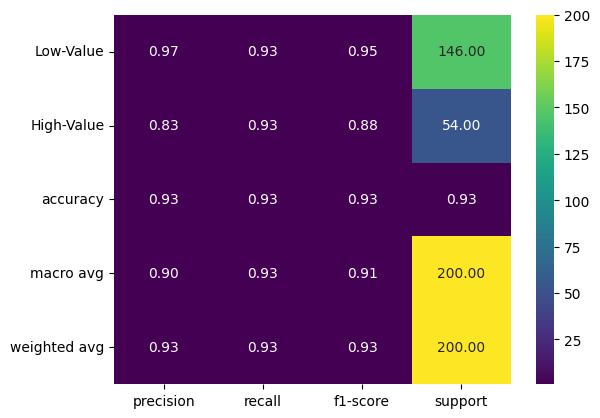

In [89]:
np.random.seed(727)

N = 1000
data = {
  'total_spending': np.random.lognormal(mean=6, sigma=1, size=N),
  'age': np.random.randint(18, 80, N),
  'num_visits': np.random.randint(1, 50, N),
  'purchase_frequency': np.random.uniform(0.5, 10, N),
  'is_high_value': np.zeros(N, dtype=int)
}

for i in range(N):
  score = (
    data['total_spending'][i] * 0.0005 +
    data['num_visits'][i] * 0.1 +
    data['purchase_frequency'][i] * 0.2
  )
  data['is_high_value'][i] = 1 if score > np.percentile([(
    data['total_spending'][j] * 0.0005 +
    data['num_visits'][j] * 0.1 +
    data['purchase_frequency'][j] * 0.2
  ) for j in range(N)], 70) else 0

df = pd.DataFrame(data)

df.loc[np.random.choice(df.index, 50), 'total_spending'] = np.nan
df.loc[np.random.choice(df.index, 30), 'purchase_frequency'] = np.nan

df['total_spending'] = df['total_spending'].fillna(df['total_spending'].median())
df['purchase_frequency'] = df['purchase_frequency'].fillna(df['purchase_frequency'].median())

def cap_outliers(series):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return series.clip(lower=lower_bound, upper=upper_bound)

for col in ['total_spending', 'num_visits', 'purchase_frequency']:
  df[col] = cap_outliers(df[col])

print("Class Distribution:")
print(df['is_high_value'].value_counts(normalize=True))

features = ['total_spending', 'age', 'num_visits', 'purchase_frequency']
X = df[features]
y = df['is_high_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

classification = classification_report(y_test, model.predict(X_test_scaled), target_names=['Low-Value', 'High-Value'], output_dict=True)
sns.heatmap(pd.DataFrame(classification).T, cmap='viridis', annot=True, fmt='.2f')

new_customer = pd.DataFrame({
  'total_spending': [1000],
  'age': [35],
  'num_visits': [20],
  'purchase_frequency': [5]
})
new_customer_scaled = scaler.transform(new_customer)
prediction = model.predict(new_customer_scaled)
print(f"Prediction: {'High-Value' if prediction[0] == 1 else 'Low-Value'}")